#초기 설정

In [2]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 55.1 MB/s eta 0:00:00


In [3]:
# import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys

# Setting our constants
sys.path.append('..')

In [4]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy

--2026-01-07 15:10:29--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32896 (32K) [application/octet-stream]
Saving to: ‘train_X.npy’

train_X.npy         100%[===================>]  32.12K  --.-KB/s    in 0.007s  

2026-01-07 15:10:29 (4.24 MB/s) - ‘train_X.npy’ saved [32896/32896]

--2026-01-07 15:10:29--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256 [

In [5]:
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

In [6]:
print(train_X.shape)
print(train_y)



(16, 256)
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


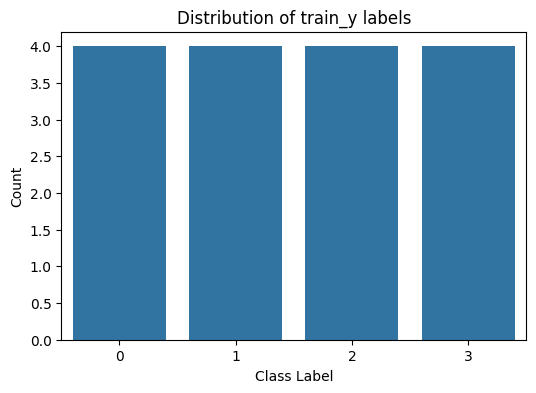

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of train_y
plt.figure(figsize=(6, 4))
sns.countplot(x=train_y)
plt.title('Distribution of train_y labels')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

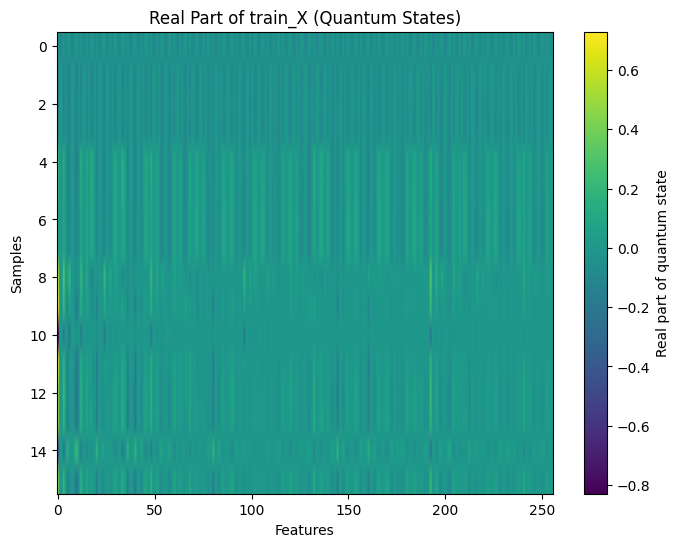

In [8]:
# Plot the real part of train_X as an image
plt.figure(figsize=(8, 6))
plt.imshow(np.real(train_X), cmap='viridis', aspect='auto')
plt.colorbar(label='Real part of quantum state')
plt.title('Real Part of train_X (Quantum States)')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

📍 Looking at sample 14 (Label: 3)

🔬 State vector shape: (256,)
🔬 First 5 amplitudes: [-4.8660690e-01+0.j -1.1920929e-07+0.j -2.6822090e-07+0.j
 -2.0963126e-01+0.j  0.0000000e+00+0.j]

📏 Normalization check (should be ≈ 1.0):
   Σ|amplitude|² = 1.000000


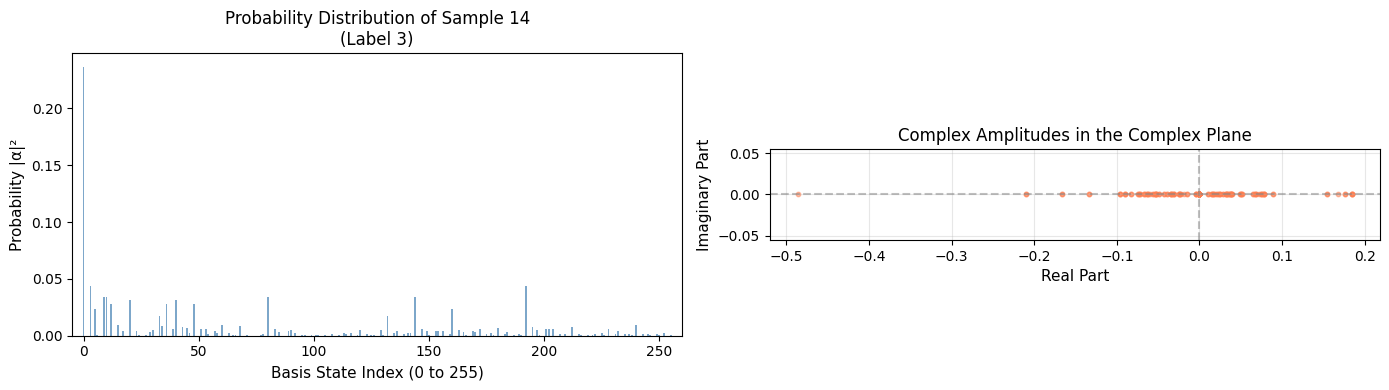


📊 Statistics:
   • Number of non-zero amplitudes: 128
   • Max probability: 0.2368 at index 0


In [15]:
# ═══════════════════════════════════════════════════════════════════════════════
# 🎯 GOAL: Visualize the probability distribution of a quantum state
# ═══════════════════════════════════════════════════════════════════════════════
sample_idx = 14
state_vector = train_X[sample_idx]

print(f"📍 Looking at sample {sample_idx} (Label: {train_y[sample_idx]})")
print(f"\n🔬 State vector shape: {state_vector.shape}")
print(f"🔬 First 5 amplitudes: {state_vector[:5]}")
print(f"\n📏 Normalization check (should be ≈ 1.0):")
print(f"   Σ|amplitude|² = {np.sum(np.abs(state_vector)**2):.6f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot 1: Probability distribution (|amplitude|²)
probabilities = np.abs(state_vector)**2
axes[0].bar(range(256), probabilities, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Basis State Index (0 to 255)', fontsize=11)
axes[0].set_ylabel('Probability |α|²', fontsize=11)
axes[0].set_title(f'Probability Distribution of Sample {sample_idx}\n(Label {train_y[sample_idx]})', fontsize=12)
axes[0].set_xlim(-5, 260)

# Plot 2: Complex amplitudes (Real vs Imaginary)
axes[1].scatter(state_vector.real, state_vector.imag, alpha=0.5, s=10, c='coral')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Real Part', fontsize=11)
axes[1].set_ylabel('Imaginary Part', fontsize=11)
axes[1].set_title('Complex Amplitudes in the Complex Plane', fontsize=12)
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"\n📊 Statistics:")
print(f"   • Number of non-zero amplitudes: {np.sum(probabilities > 1e-10)}")
print(f"   • Max probability: {np.max(probabilities):.4f} at index {np.argmax(probabilities)}")

In [10]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Inference (Model Prediction) - 기존 유지
# ==========================================
def get_predictions(model, inputs):
    """Run inference on inputs using the trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
    return predicted_labels.cpu().numpy()

def data_to_tensor(X, y):
    tensor_X = torch.tensor(X, dtype=torch.complex64)
    tensor_y = torch.tensor(y, dtype=torch.long)
    return tensor_X, tensor_y

t_train_X, t_train_y = data_to_tensor(train_X, train_y)
train_dataset = TensorDataset(t_train_X, t_train_y)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


#basecode


In [17]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)
device = "cuda" if torch.cuda.is_available() else "cpu"

def Quantum_classifier(params):
    wires = [i for i in range(n_qubits)]
    params = params.reshape(-1,3,8)
    for layer in range(params.shape[0]-1):
        for i, wire in enumerate(wires):
            qml.Rot(params[layer,0,i], params[layer,1,i], params[layer,2,i], wires=wire)
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
    for i, wire in enumerate(wires):
        qml.Rot(params[-1,0,i], params[-1,1,i], params[-1,2,i], wires=wire)



@qml.qnode(dev, interface='torch')
def linear_2qubit_block(state, params):
    wires = [i for i in range(n_qubits)]
    qml.StatePrep(state, wires=wires)
    Quantum_classifier(params)

    return qml.probs(wires=[6,7])
class QNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.total_params = 5*3*8  # 15 layers, 3 params per qubit, 8 qubits
        torch.manual_seed(42)
        self.params = nn.Parameter(torch.randn(self.total_params, requires_grad=True)*0.01)

    def forward(self, x):
        preds = linear_2qubit_block(x, self.params)
        return preds

model = QNN()
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.05)


epochs = 100
loss_history = []
acc_history = []
print(f"--- Training QNN (Params: {model.total_params}) ---")

def quantum_phase_loss(probs, labels):
    """
    Custom Loss Function based on Eq. (10) of the paper.
    Loss = 1 - (Probability of the correct class)
    """
    # probs shape: (batch_size, 4)
    # labels shape: (batch_size,)


    batch_size = probs.shape[0]

    # 정답 인덱스의 확률 추출 (Advanced Indexing)
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes=probs.shape[1])
    probs = probs
    probs = probs / torch.sum(probs, dim=1, keepdim=True)

    loss = -torch.sum(label_one_hot*torch.log(probs), dim=1)

    # 배치 평균 반환
    return torch.mean(loss)


for epoch in range(epochs):
    total_loss = 0
    correct = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X.to(device=device))
        loss = quantum_phase_loss(predictions, batch_y.to(device=device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_classes = torch.argmax(predictions, dim=1)
        batch_y = batch_y.to(predicted_classes.device)
        correct += (predicted_classes == batch_y).sum().item()

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / len(train_dataset)
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

--- Training QNN (Params: 120) ---
Epoch 20 | Loss: 1.0529 | Train Acc: 1.0000
Epoch 40 | Loss: 1.0402 | Train Acc: 1.0000
Epoch 60 | Loss: 1.0332 | Train Acc: 1.0000
Epoch 80 | Loss: 1.0224 | Train Acc: 1.0000
Epoch 100 | Loss: 1.0146 | Train Acc: 1.0000


In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. 환경 설정
n_qubits = 8
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 양자 회로 설계
def Quantum_block(params):
    # params shape: (n_layers, 3, n_qubits)
    for layer in range(params.shape[0]):
        # Rotation Layer
        for i in range(n_qubits):
            qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)

        # Entangling Layer (Ring topology)
        if layer < params.shape[0] - 1:
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i + 1) % n_qubits])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    # inputs: (256,) 형태의 정규화된 데이터
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block(params)
    # 마지막 2개 큐비트의 확률 측정 -> 2^2 = 4 클래스
    return qml.probs(wires=[6, 7])
    # return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# 3. 모델 클래스
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        # 가중치를 (layers, 3, n_qubits) 형태로 직접 선언
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)
        self.post_process = nn.Linear(n_qubits, 4)

    def forward(self, x):
        # batch 데이터를 qnode에 적용 (vmap 또는 반복문 처리)
        # PennyLane-Torch 인터페이스는 batch 입력을 지원합니다.
        return qnode(x, self.params)
        # q_out = qnode(x, self.params)
        # q_out = torch.stack(q_out, dim=1).float() # (batch_size, 8)

        # logits = self.post_process(q_out)
        # return logits

# 4. 데이터 준비 (예시)
# train_x: (16, 256), train_y: (16,)
train_x = torch.randn(16, 256)
# !! 중요 !! Amplitude Embedding을 위한 정규화
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True)
train_y = torch.tensor([0, 1, 2, 3] * 4) # 예시 레이블

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 5. 학습 설정
model = QNN(n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss() # 수치적으로 안정적인 Loss

# # 6. 학습 루프
# epochs = 100
# for epoch in range(epochs):
#     avg_loss = 0
#     correct = 0
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)

#         optimizer.zero_grad()
#         # forward 시 qml.probs 결과값은 (batch, 4)
#         predictions = model(batch_X)

#         # log_softmax를 취해주는 것이 CrossEntropyLoss 사용 시 좋습니다.
#         # qml.probs는 확률이므로 log를 직접 취하거나 모델 끝에 epsilon을 더해줌
#         loss = criterion(torch.log(predictions + 1e-10), batch_y)

#         loss.backward()
#         optimizer.step()
#         avg_loss += loss.item() / len(train_loader)
#         predicted_classes = torch.argmax(predictions, dim=1)
#         correct += (predicted_classes == batch_y).sum().item()

#     avg_acc = correct / len(train_dataset)
#     if (epoch + 1) % 20 == 0:
#         print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

##SGD with momentum 적용

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 4  # 고전 층이 없으므로 레이어를 약간 늘려 표현력을 보강합니다.
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계
def Quantum_block(params):
    for layer in range(params.shape[0]):
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

        # Rotation Layer
        for i in range(n_qubits):
            # qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

        # Entangling Layer (강력한 얽힘을 위해 Ring + Skip 구조 사용)
        # for i in range(n_qubits):
        #     qml.CNOT(wires=[i, (i + 1) % n_qubits])
        # if layer % 2 == 1: # 징검다리 얽힘 추가
        #     for i in range(n_qubits):
        #         qml.CNOT(wires=[i, (i + 2) % n_qubits])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block(params)
    # 제약 조건: 2개 큐비트의 확률 측정 (4개 클래스)
    return qml.probs(wires=[6, 7])

# 2. 모델 클래스 (nn.Linear 제거)
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        # 오직 양자 회로의 가중치만 가집니다.
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)

    def forward(self, x):
        # qnode가 직접 (batch_size, 4) 형태의 확률을 반환합니다.
        probs = qnode(x, self.params)
        return probs

# 3. 데이터 준비 및 정규화 (매우 중요)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True) # L2 정규화
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. 학습 설정
model = QNN(n_layers).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# criterion = nn.NLLLoss() # 확률값의 로그를 취하므로 NLLLoss가 적합합니다.
criterion = nn.CrossEntropyLoss()

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        loss = nn.functional.nll_loss(log_probs, batch_y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_x):.4f}")

Epoch 20 | Loss: 1.1466 | Train Acc: 1.0000
Epoch 40 | Loss: 1.0751 | Train Acc: 1.0000
Epoch 60 | Loss: 1.0673 | Train Acc: 1.0000
Epoch 80 | Loss: 1.0616 | Train Acc: 1.0000
Epoch 100 | Loss: 1.0352 | Train Acc: 1.0000
Epoch 120 | Loss: 1.0332 | Train Acc: 1.0000
Epoch 140 | Loss: 1.0297 | Train Acc: 1.0000
Epoch 160 | Loss: 1.0268 | Train Acc: 1.0000
Epoch 180 | Loss: 1.0233 | Train Acc: 1.0000
Epoch 200 | Loss: 1.0202 | Train Acc: 1.0000
Epoch 220 | Loss: 1.0182 | Train Acc: 1.0000
Epoch 240 | Loss: 1.0164 | Train Acc: 1.0000
Epoch 260 | Loss: 1.0125 | Train Acc: 1.0000
Epoch 280 | Loss: 1.0096 | Train Acc: 1.0000
Epoch 300 | Loss: 1.0074 | Train Acc: 1.0000


#circuit 변경

In [ ]:
from networkx.readwrite.graph6 import n_to_data
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 5 # 고전 층이 없으므로 레이어를 약간 늘려 표현력을 보강합니다.
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계
def Quantum_block2(params):
    for i in range(n_qubits):
          qml.Hadamard(wires=i)
    for layer in range(params.shape[0]-1):

        # if layer== 0:
        #   for i in range(n_qubits):
        #     qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)
        # else:
        #   # Rotation Layer
        #   if layer % 3 == 0:
        #       for i in range(n_qubits):
        #           qml.RX(params[layer, 0, i], wires=i)
        #   if layer % 3 == 1:
        #       for i in range(n_qubits):
        #           qml.RY(params[layer, 1, i], wires=i)
        #   if layer % 3 == 2:
        #       for i in range(n_qubits):
        #           qml.RZ(params[layer, 2, i], wires=i)
        # qml.Hadamard(wires=(layer % n_qubits))
        # for i in range(n_qubits
        # Rotation Layer
        # if layer % 2 == 0:
        #     for i in range(n_qubits):
        #         qml.CNOT(wires=[i, (i + 1) % n_qubits])
        # if layer % 2 == 1: # 징검다리 얽힘 추가
        #     for i in range(n_qubits):
        #         qml.CNOT(wires=[i, (i + 2) % n_qubits])
        # for layer in range(n_layers):
        # if layer % 2 == 0:
        #     for i in range(n_qubits):
        #         qml.Hadamard(wires=i)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + layer+1) % n_qubits])

        for i in range(n_qubits):
            # qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

        # Entangling Layer (강력한 얽힘을 위해 Ring + Skip 구조 사용)
        # if layer % 2 == 0:
        #     for i in range(n_qubits):
        #         qml.Hadamard(wires=i)
        #         qml.CNOT(wires=[i, (i + 1) % n_qubits])
        # else:
        #   for i in range(n_qubits):
        #       # qml.Hadamard(wires=i)
        #       qml.CNOT(wires=[i, (i + 1) % n_qubits])

        # if layer % 2 == 0:
        #     # 짝수 레이어: 순방향 (0->1, 1->2 ...)
        #     for i in range(n_qubits):
        #         qml.CNOT(wires=[i, (i + 1) % n_qubits])
        # else:
        #     # 홀수 레이어: 역방향 (7->6, 6->5 ...)
        #     for i in range(n_qubits - 1, -1, -1):
        #         qml.CNOT(wires=[i, (i - 1) % n_qubits])

    for i in range(0,4):
        qml.CNOT(wires=[i, (i + 1) % 4])
    for i in range(0,4):
        qml.Rot(params[4, 0, i], params[4, 1, i], params[4, 2, i], wires=i)
    for i in range(0,4):
        qml.CNOT(wires=[i, (i + 2) % 4])

    for i in range(n_qubits):
        qml.Hadamard(wires=i)

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block2(params)
    # 제약 조건: 2개 큐비트의 확률 측정 (4개 클래스)
    return qml.probs(wires=[0, 1])

# 2. 모델 클래스 (nn.Linear 제거)
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        # 오직 양자 회로의 가중치만 가집니다.
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.001)

    def forward(self, x):
        # qnode가 직접 (batch_size, 4) 형태의 확률을 반환합니다.
        probs = qnode(x, self.params)
        return probs

# 3. 데이터 준비 및 정규화 (매우 중요)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True) # L2 정규화
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 4. 학습 설정
model = QNN(n_layers).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.NLLLoss() # 확률값의 로그를 취하므로 NLLLoss가 적합합니다.
# criterion = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        # loss = nn.functional.nll_loss(log_probs, batch_y)
        loss = quantum_phase_loss(probs, batch_y.to(device=device))

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()
    # scheduler.step()

    if (epoch + 1) % 20 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Acc: {correct/len(train_x):.4f} | LR: {current_lr:.6f}")

##k-겹 교차 검증 코드

In [ ]:
import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset, TensorDataset

# 설정값
k_folds = 10
epochs = 300
batch_size = 8 # 기존에 정의된 값 사용

# KFold 객체 생성
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 전체 데이터셋 생성 (이미 Tensor 형태라고 가정: train_x, train_y)
full_dataset = TensorDataset(train_x, train_y)
fold_train_losses = []
fold_val_accuracies = []

print(f"--- {k_folds}-Fold Cross Validation 시작 ---")

for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
    train_loss_history = [] # 현재 폴드의 에폭별 loss 기록
    print(f"\nFOLD {fold + 1}")
    print("-" * 20)

    # 데이터 나누기
    train_subsampler = Subset(full_dataset, train_ids)
    val_subsampler = Subset(full_dataset, val_ids)

    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # --- 모델 및 옵티마이저 초기화 (매 폴드마다 새로 시작해야 함) ---
    # model = MyQuantumModel().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # ---------------------------------------------------------
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    model = QNN(n_layers).to(device)

    for epoch in range(epochs):
        model.train() # 학습 모드
        avg_loss = 0
        correct = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            probs = model(batch_X)

            # 손실 함수 계산 (작성하신 코드 유지)
            loss = quantum_phase_loss(probs, batch_y)

            loss.backward()
            optimizer.step()

            avg_loss += loss.item() / len(train_loader)
            predicted_classes = torch.argmax(probs, dim=1)
            correct += (predicted_classes == batch_y).sum().item()
            train_loss_history.append(avg_loss) # 매 에폭 loss 저장

        # 에폭별 로그 출력 (선택 사항)
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1:02d} | Train Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_subsampler):.4f}")

    # --- 폴드 종료 후 검증 (Validation) ---
    fold_train_losses.append(train_loss_history)
    fold_val_accuracies.append(val_correct / len(val_subsampler))
    model.eval() # 평가 모드
    val_correct = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            probs = model(batch_X)
            val_predicted = torch.argmax(probs, dim=1)
            val_correct += (val_predicted == batch_y).sum().item()

    print(f"FOLD {fold + 1} 결과 | Val Acc: {val_correct/len(val_subsampler):.4f}")

--- 10-Fold Cross Validation 시작 ---

FOLD 1
--------------------
Epoch 100 | Train Loss: 1.2979 | Train Acc: 0.3571
Epoch 200 | Train Loss: 1.3046 | Train Acc: 0.3571
Epoch 300 | Train Loss: 1.3079 | Train Acc: 0.3571
FOLD 1 결과 | Val Acc: 0.5000

FOLD 2
--------------------
Epoch 100 | Train Loss: 1.3023 | Train Acc: 0.3571
Epoch 200 | Train Loss: 1.3091 | Train Acc: 0.3571
Epoch 300 | Train Loss: 1.3029 | Train Acc: 0.3571
FOLD 2 결과 | Val Acc: 0.5000

FOLD 3
--------------------
Epoch 100 | Train Loss: 1.3080 | Train Acc: 0.2857
Epoch 200 | Train Loss: 1.3023 | Train Acc: 0.2857
Epoch 300 | Train Loss: 1.2993 | Train Acc: 0.2857
FOLD 3 결과 | Val Acc: 1.0000

FOLD 4
--------------------
Epoch 100 | Train Loss: 1.2883 | Train Acc: 0.4286
Epoch 200 | Train Loss: 1.2784 | Train Acc: 0.4286
Epoch 300 | Train Loss: 1.2927 | Train Acc: 0.4286
FOLD 4 결과 | Val Acc: 0.0000

FOLD 5
--------------------
Epoch 100 | Train Loss: 1.2805 | Train Acc: 0.3571


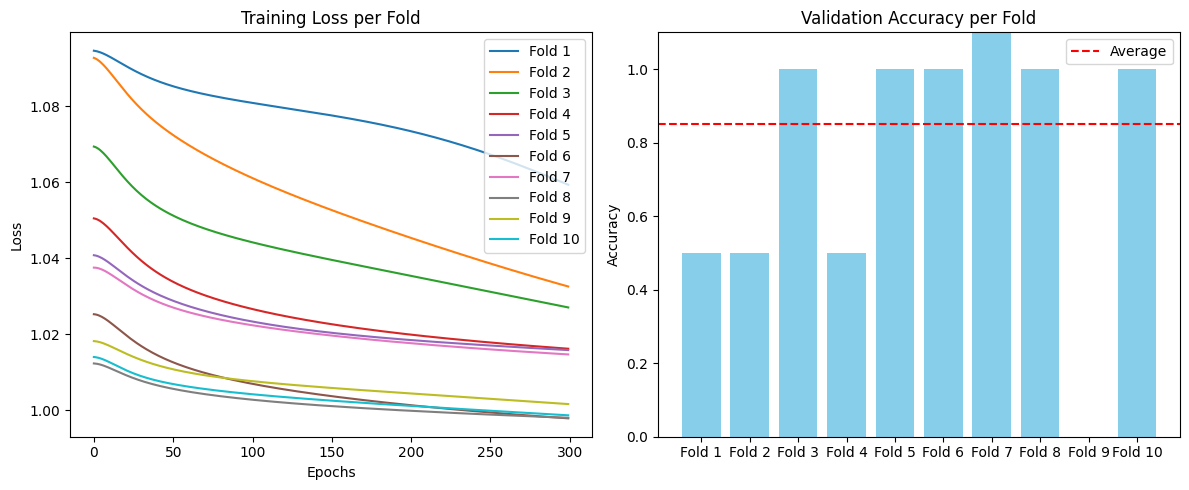

In [133]:
plt.figure(figsize=(12, 5))

# --- 그래프 1: 모든 Fold의 Loss 추이 ---
plt.subplot(1, 2, 1)
for i, loss_hist in enumerate(fold_train_losses):
    plt.plot(loss_hist, label=f'Fold {i+1}')
plt.title('Training Loss per Fold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- 그래프 2: Fold별 최종 검증 정확도 (Bar Chart) ---
plt.subplot(1, 2, 2)
folds = [f'Fold {i+1}' for i in range(k_folds)]
plt.bar(folds, fold_val_accuracies, color='skyblue')
plt.axhline(y=sum(fold_val_accuracies)/k_folds, color='r', linestyle='--', label='Average')
plt.title('Validation Accuracy per Fold')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1) # 정확도는 0~1 사이
plt.legend()

plt.tight_layout()
plt.show()

Epoch 300 | Loss: 0.8849 | Train Acc: 1.0000

Epoch 300 | Loss: 0.8388 | Train Acc: 1.0000

Epoch 300 | Loss: 0.8498 | Train Acc: 1.0000

##circuit 기록


In [120]:
qml.draw_mpl(qnode)(batch_X,model.params)

AttributeError: 'QuantumRandomForest' object has no attribute 'params'

In [ ]:
qml.draw_mpl(qnode)(batch_X,model.params)

#Epoch 300 | Loss: 0.8477 | Train Acc: 1.0000

def Quantum_block2(params):
    for i in range(n_qubits):
          qml.Hadamard(wires=i)
    for layer in range(params.shape[0]):
        for i in range(n_qubits):
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

        # Entangling Layer (강력한 얽힘을 위해 Ring + Skip 구조 사용)
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
        if layer % 2 == 1: # 징검다리 얽힘 추가
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i + 2) % n_qubits])

In [ ]:
qml.draw_mpl(qnode)(batch_X,model.params)

#Epoch 300 | Loss: 0.9285 | Train Acc: 1.0000


In [ ]:
qml.draw_mpl(qnode)(batch_X,model.params)

#Epoch 300 | Loss: 0.8211 | Train Acc: 1.0000

def Quantum_block2(params):
    for i in range(n_qubits):
          qml.Hadamard(wires=i)
    for layer in range(params.shape[0]):

        for i in range(n_qubits):
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

        # Entangling Layer (강력한 얽힘을 위해 Ring + Skip 구조 사용)
        if layer % 2 == 0:
            for i in range(n_qubits):
                qml.Hadamard(wires=i)
                qml.CNOT(wires=[i, (i + 1) % n_qubits])
        else:
          for i in range(n_qubits):
              qml.CNOT(wires=[i, (i + 1) % n_qubits])

    for i in range(n_qubits):
          qml.Hadamard(wires=i)

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block2(params)
    # 제약 조건: 2개 큐비트의 확률 측정 (4개 클래스)
    return qml.probs(wires=[6, 7])

In [ ]:
qml.draw_mpl(qnode)(batch_X,model.params)

#Epoch 300 | Loss: 0.7632 | Train Acc: 1.0000

def Quantum_block2(params):
    for i in range(n_qubits):
          qml.Hadamard(wires=i)
    for layer in range(params.shape[0]):

        for i in range(n_qubits):
            # qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
        if layer % 2 == 1: # 징검다리 얽힘 추가
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i + 2) % n_qubits])

    for i in range(n_qubits):
          qml.Hadamard(wires=i)

In [ ]:
def Quantum_block2(params):
    for i in range(n_qubits):
          qml.Hadamard(wires=i)
    for layer in range(params.shape[0]):

        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + layer+1) % n_qubits])

        for i in range(n_qubits):
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

    for i in range(n_qubits):
        qml.Hadamard(wires=i)

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block2(params)
    # 제약 조건: 2개 큐비트의 확률 측정 (4개 클래스)
    return qml.probs(wires=[6, 7])

qml.draw_mpl(qnode)(batch_X,model.params)

#얽힘 시각화

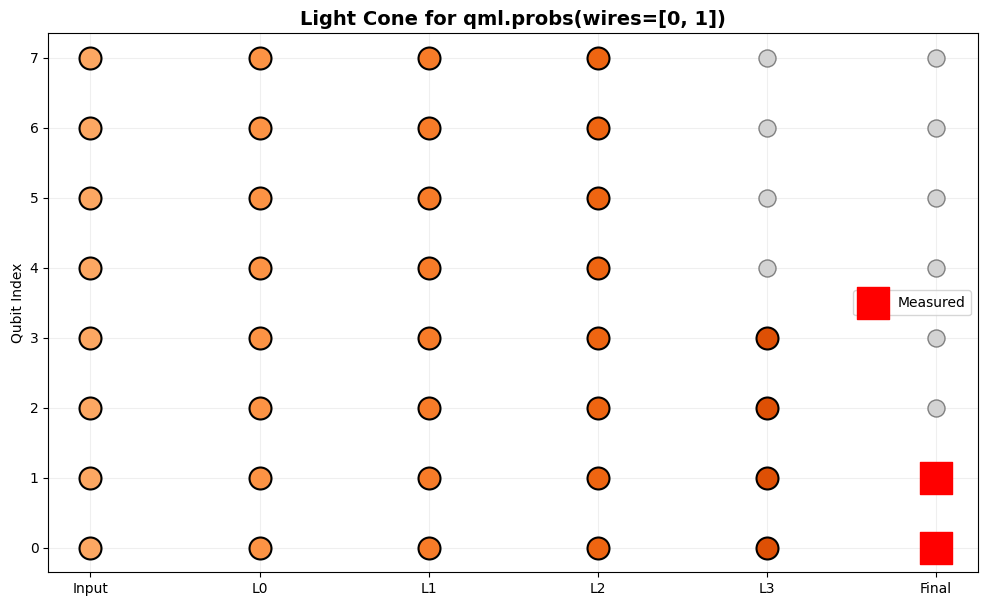

💡 초기 입력 큐비트 중 100.0%가 최종 측정([0, 1])에 기여합니다.


In [107]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_custom_light_cone(n_qubits, n_layers, measure_qubits):
    fig, ax = plt.subplots(figsize=(12, 7))

    # 1. 그리드 초기화 (모든 큐비트 지점)
    for layer in range(n_layers + 2): # StatePrep(L0) + Layers + Final Meas
        for qubit in range(n_qubits):
            ax.scatter(layer, qubit, s=150, c='lightgray', zorder=2, edgecolors='gray')

    # 2. 역방향 빛의 원추(Backward Light Cone) 계산
    # influenced[layer] = {해당 레이어에서 측정에 영향을 주는 큐비트들}
    influenced = {n_layers + 1: set(measure_qubits)}

    # 마지막 Rot & CNOT 블록 (코드 하단의 i, (i+1)%4 등 반영)
    current_layer = n_layers + 1
    prev_layer = n_layers
    influenced[prev_layer] = set(influenced[current_layer])

    # 마지막 부분의 CNOT들 역추적 (i+2 % 4, i+1 % 4)
    for q in list(influenced[prev_layer]):
        # qml.CNOT(wires=[i, (i + 2) % 4]) 역추적
        for i in range(4):
            target = (i + 2) % 4
            if q == target: influenced[prev_layer].add(i)
            if q == i: influenced[prev_layer].add(target)
        # qml.CNOT(wires=[i, (i + 1) % 4]) 역추적
        for i in range(4):
            target = (i + 1) % 4
            if q == target: influenced[prev_layer].add(i)
            if q == i: influenced[prev_layer].add(target)

    # 중간 반복 레이어 (Quantum_block2의 루프) 역추적
    for l_idx in range(n_layers - 1, -1, -1):
        influenced[l_idx] = set(influenced[l_idx + 1])
        for q in list(influenced[l_idx + 1]):
            # qml.CNOT(wires=[i, (i + layer + 1) % n_qubits])
            step = l_idx + 1
            for i in range(n_qubits):
                target = (i + step) % n_qubits
                if q == target: influenced[l_idx].add(i)
                if q == i: influenced[l_idx].add(target)

    # 3. 시각화 (영향을 받는 큐비트 색칠)
    colors = plt.cm.Oranges(np.linspace(0.4, 0.8, n_layers + 2))
    for layer, qubits in influenced.items():
        for q in qubits:
            ax.scatter(layer, q, s=250, c=[colors[layer]],
                       zorder=3, edgecolors='black', linewidths=1.5)

    # 측정 위치 표시 (wires=[0, 1])
    for mq in measure_qubits:
        ax.scatter(n_layers + 1, mq, s=500, c='red', marker='s', zorder=4, label='Measured' if mq==0 else "")

    # 레이블링
    ax.set_xticks(range(n_layers + 2))
    ax.set_xticklabels(['Input'] + [f'L{i}' for i in range(n_layers)] + ['Final'])
    ax.set_ylabel("Qubit Index")
    ax.set_title(f"Light Cone for qml.probs(wires={measure_qubits})", fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.2)
    plt.legend()
    plt.show()

    coverage = len(influenced[0]) / n_qubits * 100
    print(f"💡 초기 입력 큐비트 중 {coverage:.1f}%가 최종 측정({measure_qubits})에 기여합니다.")

# 실행 (n_qubits=8, layers=4(params 기준))
visualize_custom_light_cone(n_qubits=8, n_layers=4, measure_qubits=[0, 1])

In [110]:
import pennylane as qml
from pennylane import numpy as np

# 설정
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

def Quantum_block2(params):
    # 1. 초기 상태 형성
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # 2. 메인 레이어 (얽힘 확산)
    for layer in range(params.shape[0]-1):
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + layer + 1) % n_qubits])
        for i in range(n_qubits):
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

    # 3. 추가 로컬 얽힘 (0~3번 큐비트)
    for i in range(0, 4):
        qml.CNOT(wires=[i, (i + 1) % 4])
    for i in range(0, 4):
        qml.Rot(params[4, 0, i], params[4, 1, i], params[4, 2, i], wires=i)
    for i in range(0, 4):
        qml.CNOT(wires=[i, (i + 2) % 4])

    for i in range(n_qubits):
        qml.Hadamard(wires=i)

@qml.qnode(dev)
def get_entanglement_entropy(params, target_wires):
    """특정 큐비트(target_wires)와 나머지 사이의 얽힘 엔트로피 계산"""
    Quantum_block2(params)
    # 폰 노이만 엔트로피 반환 (0이면 얽힘 없음, 1에 가까울수록 최대 얽힘)
    return qml.vn_entropy(wires=target_wires)

# 무작위 파라미터 생성 (5개 레이어, 3개 회전축, n개 큐비트)
params = np.random.random((5, 3, n_qubits))

# 0, 1번 큐비트가 전체 시스템과 얼마나 얽혀 있는지 확인
entropy = get_entanglement_entropy(params, target_wires=[0, 1])

print(f"📊 측정 큐비트 [0, 1]의 얽힘 엔트로피: {entropy:.4f}")

📊 측정 큐비트 [0, 1]의 얽힘 엔트로피: 1.3737


#strongly entanglement layer add

In [50]:
def feature_map_block(params):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    # for i in range(n_qubits):
    #     qml.RX(params[0, 0, i], wires=i)
    #     qml.RY(params[0, 1, i], wires=i)
    #     qml.RZ(params[0, 2, i], wires=i)

def Ansatz_block(params):
    qml.StronglyEntanglingLayers(weights=params[1, 0:3, :4].T.unsqueeze(0), wires=range(4))
    qml.StronglyEntanglingLayers(weights=params[1, 0:3, 4:n_qubits].T.unsqueeze(0), wires=range(4, n_qubits))
    qml.StronglyEntanglingLayers(weights=params[2, 0:3, :4].T.unsqueeze(0), wires=[0,1,4,5])


In [59]:
from networkx.readwrite.graph6 import n_to_data
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 5 # 고전 층이 없으므로 레이어를 약간 늘려 표현력을 보강합니다.
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계
def Quantum_block2(params):
    feature_map_block(params)
    Ansatz_block(params)
    # for layer in range(n_layers):
    #     for i in range(n_qubits):
    #         qml.StronglyEntanglingLayers(weights=params[layer, 3, i], wires=range(8))
    # for layer in range(0, n_layers):

    # for i in range(4):
    #     # qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)
    #     qml.RX(params[2, 0, i], wires=i)
    #     qml.RY(params[2, 1, i], wires=i)
    #     qml.RZ(params[2, 2, i], wires=i)
    # for i in range(4,n_qubits):
    #     # qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)
    #     qml.RX(params[2, 0, i], wires=i)
    #     qml.RY(params[2, 1, i], wires=i)
    #     qml.RZ(params[2, 2, i], wires=i)
    #         # qml.StronglyEntanglingLayers(weights=params[layer, 3, i], wires=range(8))
    # for i in range(n_qubits):
    #       qml.Hadamard(wires=i)

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block2(params)
    # 제약 조건: 2개 큐비트의 확률 측정 (4개 클래스)
    return qml.probs(wires=[0, 1])

# 2. 모델 클래스 (nn.Linear 제거)
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        # 오직 양자 회로의 가중치만 가집니다.
        self.params = nn.Parameter(torch.randn(n_layers, 4, n_qubits) * 0.01)

    def forward(self, x):
        # qnode가 직접 (batch_size, 4) 형태의 확률을 반환합니다.
        probs = qnode(x, self.params)
        return probs

# 3. 데이터 준비 및 정규화 (매우 중요)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True) # L2 정규화
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. 학습 설정
model = QNN(n_layers).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.NLLLoss() # 확률값의 로그를 취하므로 NLLLoss가 적합합니다.
# criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# 5. 학습 루프
epochs = 100
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        loss = quantum_phase_loss(probs, batch_y.to(device=device))

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()
    scheduler.step()

    if (epoch + 1) % 20 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Acc: {correct/len(train_x):.4f} | LR: {current_lr:.6f}")

Epoch 20 | Loss: 1.2576 | Acc: 0.5000 | LR: 0.100000
Epoch 40 | Loss: 1.1937 | Acc: 0.8750 | LR: 0.100000
Epoch 60 | Loss: 1.1801 | Acc: 0.9375 | LR: 0.100000
Epoch 80 | Loss: 1.1760 | Acc: 0.8750 | LR: 0.100000
Epoch 100 | Loss: 1.1752 | Acc: 0.8750 | LR: 0.010000


(<Figure size 1100x900 with 1 Axes>, <Axes: >)

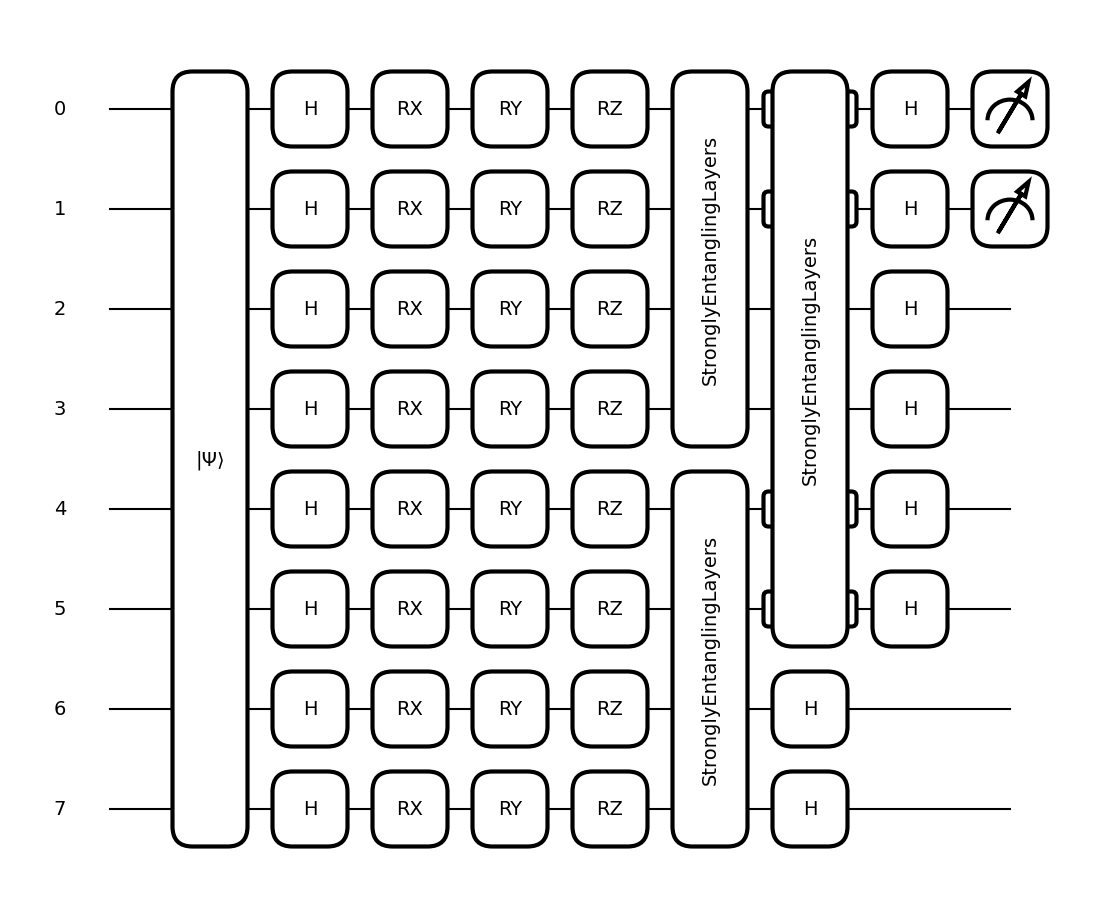

In [54]:
qml.draw_mpl(qnode)(batch_X,model.params)

#랜덤 포레스트

In [118]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np

# 설정 유지
n_qubits = 8
n_trees = 3  # 랜덤 포레스트의 트리 개수 (앙상블 개수)
n_layers = 5 # 각 트리당 레이어 수
dev = qml.device("default.qubit", wires=n_qubits)
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- 양자 회로 설계 (기존 코드 유지) ---
def Quantum_classifier(params):
    wires = list(range(n_qubits))
    params = params.reshape(-1, 3, n_qubits)
    for layer in range(params.shape[0]-1):
        for i, wire in enumerate(wires):
            qml.Rot(params[layer,0,i], params[layer,1,i], params[layer,2,i], wires=wire)
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
    # Last rotation layer
    for i, wire in enumerate(wires):
        qml.Rot(params[-1,0,i], params[-1,1,i], params[-1,2,i], wires=wire)

@qml.qnode(dev, interface='torch')
def linear_2qubit_block(state, params):
    qml.StatePrep(state, wires=range(n_qubits))
    Quantum_classifier(params)
    return qml.probs(wires=[6, 7]) # 4개 클래스 예측

# --- 개별 트리(Weak Learner) 클래스 ---
class QuantumTree(nn.Module):
    def __init__(self):
        super().__init__()
        self.total_params = n_layers * 3 * n_qubits
        self.params = nn.Parameter(torch.randn(self.total_params) * 0.01)

    def forward(self, x):
        # x: (batch_size, 2^n_qubits)
        # PennyLane QNode는 배치 처리를 지원하므로 매핑 적용
        # (노트: 데이터 크기에 따라 vmap이나 반복문이 필요할 수 있으나 최신 버전은 배치 지원)
        return linear_2qubit_block(x, self.params)

# --- 앙상블 모델 (Random Forest) ---
class QuantumRandomForest(nn.Module):
    def __init__(self, num_trees):
        super().__init__()
        # 여러 개의 양자 트리를 리스트로 관리
        self.trees = nn.ModuleList([QuantumTree() for _ in range(num_trees)])
        self.num_trees = num_trees

    def forward(self, x):
        # 1. 각 트리의 예측값 수집 (Soft Voting 방식)
        # tree_outputs shape: (num_trees, batch_size, 4)
        tree_outputs = torch.stack([tree(x) for tree in self.trees])

        # 2. 모든 트리의 결과 평균내기
        # final_probs shape: (batch_size, 4)
        final_probs = torch.mean(tree_outputs, dim=0)
        return final_probs

# --- 모델 초기화 및 학습 설정 ---
model = QuantumRandomForest(num_trees=n_trees).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05)

# Loss 함수 (기존 코드 유지)
def quantum_phase_loss(probs, labels):
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes=probs.shape[1]).to(probs.device)
    # 수치적 안정성을 위한 epsilon 추가
    probs = torch.clamp(probs, min=1e-9, max=1.0)
    loss = -torch.sum(label_one_hot * torch.log(probs), dim=1)
    return torch.mean(loss)

epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        loss = quantum_phase_loss(probs, batch_y.to(device=device))

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    if (epoch + 1) % 20 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Acc: {correct/len(train_x):.4f}")

print(f"--- Training Quantum Random Forest (Trees: {n_trees}, Total Params: {n_trees * n_layers * 3 * n_qubits}) ---")

Epoch 20 | Loss: 1.0855 | Acc: 1.0000
Epoch 40 | Loss: 1.0384 | Acc: 1.0000
Epoch 60 | Loss: 1.0194 | Acc: 1.0000
Epoch 80 | Loss: 1.0132 | Acc: 1.0000
Epoch 100 | Loss: 1.0036 | Acc: 1.0000
Epoch 120 | Loss: 0.9991 | Acc: 1.0000
Epoch 140 | Loss: 0.9952 | Acc: 1.0000
Epoch 160 | Loss: 0.9902 | Acc: 1.0000
Epoch 180 | Loss: 0.9882 | Acc: 1.0000
Epoch 200 | Loss: 0.9875 | Acc: 1.0000
Epoch 220 | Loss: 0.9873 | Acc: 1.0000
Epoch 240 | Loss: 0.9868 | Acc: 1.0000
Epoch 260 | Loss: 0.9866 | Acc: 1.0000
Epoch 280 | Loss: 0.9851 | Acc: 1.0000
Epoch 300 | Loss: 0.9847 | Acc: 1.0000
--- Training Quantum Random Forest (Trees: 3, Total Params: 360) ---



Layer Norm 적용

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 4
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계 (기존과 동일)
def Quantum_block(params):
    for layer in range(params.shape[0]):
        for i in range(n_qubits):
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block(params)
    return qml.probs(wires=[6, 7]) # 4개 클래스 확률 반환

# 2. 모델 클래스 (LayerNorm 추가)
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)

        # Layer Normalization 추가: 입력 피처 크기는 qml.probs의 결과인 4
        # elementwise_affine=True로 설정하면 학습 가능한 gamma, beta가 포함됩니다.
        # self.ln = nn.LayerNorm(4)

    def forward(self, x):
        # 1. QNode 실행 (batch_size, 4)
        probs = qnode(x, self.params)

        eps = 1e-6
        mean = probs.mean(dim=-1, keepdim=True)
        var = probs.var(dim=-1, keepdim=True, unbiased=False)

        # 이 연산은 파라미터 업데이트가 없는 단순 '스케일링'입니다.
        normalized_out = (probs - mean) / torch.sqrt(var + eps)

        return probs

# 3. 데이터 준비 (기존과 동일)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True)
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. 학습 설정
model = QNN(n_layers).to(device)
# SGD with Momentum 유지
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# LayerNorm이 적용되면 출력값이 확률 범위를 벗어날 수 있으므로
# CrossEntropyLoss를 사용하는 것이 수치적으로 훨씬 안정적입니다.
criterion = nn.CrossEntropyLoss()

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()

        # 모델 출력 (정규화된 값)
        outputs = model(batch_X)

        # CrossEntropyLoss는 내부적으로 Softmax를 포함하므로
        # LayerNorm 이후의 값을 그대로 넣으면 됩니다.
        eps = 1e-6
        mu = outputs.mean(dim=-1, keepdim=True)
        std = outputs.std(dim=-1, keepdim=True)
        norm_out = (outputs - mu) / (std + eps)

        # 3. 정규화된 값으로 Loss 계산
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(outputs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_x):.4f}")

# total_epochs = 300
# fine_tune_epochs = 250  # 마지막에 정규화 없이 학습할 에포크 수
# norm_stage_epochs = total_epochs - fine_tune_epochs

# # criterion = nn.NLLLoss() # 확률값에 log를 취해 전달하므로 NLLLoss 사용
# eps = 1e-6

# for epoch in range(total_epochs):
#     avg_loss = 0
#     is_fine_tuning = (epoch >= norm_stage_epochs) # Fine-tuning 단계 여부

#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         optimizer.zero_grad()

#         # 1. 양자 회로 실행 (Pure 확률값)
#         probs = model(batch_X)

#         if not is_fine_tuning:
#             # [단계 1: 정규화 학습] SGD Momentum이 길을 잘 잡도록 가이드
#             mean = probs.mean(dim=-1, keepdim=True)
#             std = probs.std(dim=-1, keepdim=True)
#             processed_out = (probs - mean) / (std + eps)

#             # 정규화된 출력에는 CrossEntropy가 수치적으로 더 안정적입니다.
#             loss = nn.functional.cross_entropy(processed_out, batch_y)
#         else:
#             # [단계 2: Fine-tuning] 정규화 없이 실전(QASM) 환경에 적응
#             # 0이 되어 log가 터지는 것을 방지하기 위해 eps 더함
#             log_probs = torch.log(probs + 1e-10)
#             loss = nn.functional.nll_loss(log_probs, batch_y)

#         loss.backward()
#         optimizer.step()
#         avg_loss += loss.item() / len(train_loader)

#     # 로그 출력
#     stage_name = "Fine-tuning" if is_fine_tuning else "Norm Training"
#     if (epoch + 1) % 10 == 0: #or is_fine_tuning:
#         print(f"Epoch [{epoch+1}/{total_epochs}] | Stage: {stage_name} | Loss: {avg_loss:.4f}")

Epoch 20 | Loss: 1.3728 | Train Acc: 0.4375
Epoch 40 | Loss: 1.3625 | Train Acc: 0.5000
Epoch 60 | Loss: 1.3559 | Train Acc: 0.6875
Epoch 80 | Loss: 1.3516 | Train Acc: 0.6875
Epoch 100 | Loss: 1.3484 | Train Acc: 0.7500
Epoch 120 | Loss: 1.3456 | Train Acc: 0.7500
Epoch 140 | Loss: 1.3426 | Train Acc: 0.7500
Epoch 160 | Loss: 1.3391 | Train Acc: 0.8125
Epoch 180 | Loss: 1.3347 | Train Acc: 0.8125
Epoch 200 | Loss: 1.3295 | Train Acc: 0.8750
Epoch 220 | Loss: 1.3238 | Train Acc: 0.8750
Epoch 240 | Loss: 1.3180 | Train Acc: 0.8750
Epoch 260 | Loss: 1.3127 | Train Acc: 0.9375
Epoch 280 | Loss: 1.3082 | Train Acc: 1.0000
Epoch 300 | Loss: 1.3046 | Train Acc: 1.0000


#CNN 구현

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 4  # 고전 층이 없으므로 레이어를 약간 늘려 표현력을 보강합니다.
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계
def conv_layer(wires, params):
    """인접한 큐비트들을 얽어 특징을 추출하는 층 (Convolution)"""
    for i in range(len(wires)):
        # qml.Rot(params[i, 0], params[i, 1], params[i, 2], wires=wires[i])
        qml.RX(params[i, 0], wires=i)
        qml.RY(params[i,1], wires=i)
        qml.RZ(params[i, 2], wires=i)
    for i in range(len(wires)):
        qml.CNOT(wires=[wires[i], wires[(i + 1) % len(wires)]])

def pooling_layer(v_wires, s_wires, params):
    """정보를 s_wires로 압축하는 층 (Pooling)"""
    # v_wires: 버려질 큐비트들, s_wires: 살아남을 큐비트들
    for i in range(len(s_wires)):
        qml.CRot(params[i, 0], params[i, 1], params[i, 2], wires=[v_wires[i], s_wires[i]])

def hadamard_layer(wires):
    for i in wires:
        qml.Hadamard(wires=i)
def Qcnn_block(params):
    # 각 유닛이 사용할 수 있게 모양을 재구성(Reshape)하거나 넉넉하게 할당합니다.
    # conv_layer는 최대 8개의 큐비트를 다루므로 (8, 3) = 24개가 필요
    # pooling_layer는 최대 4개의 쌍을 다루므로 (4, 3) = 12개가 필요
    # 총 36개의 파라미터가 필요합니다.
    conv_w = params[0:24].reshape(8, 3)
    pool_w = params[24:36].reshape(4, 3)

    # wires = range(8)
    # for i in range(len(wires)):
    #     qml.CNOT(wires=[wires[i], wires[(i + 1) % len(wires)]])

    hadamard_layer(range(8))
    # Layer 1: 8개 큐비트 전체 Convolution
    conv_layer(range(8), conv_w)

    # Layer 2: 8 -> 4 Pooling (0,2,4,6 -> 1,3,5,7)
    pooling_layer([0, 2, 4, 6], [1, 3, 5, 7], pool_w)

    # Layer 3: 남은 4개 Convolution (슬라이싱으로 4개만 사용)
    conv_layer([1, 3, 5, 7], conv_w[:4])

    # Layer 4: 4 -> 2 Pooling (1,5 -> 3,7)
    pooling_layer([1, 5], [3, 7], pool_w[:2])

    qml.Hadamard(wires=3)
    qml.Hadamard(wires=7)

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(8))
    Qcnn_block(params)

    # 최종적으로 정보가 모인 3, 7번 큐비트의 확률 측정
    return qml.probs(wires=[3, 7])

# 2. 모델 클래스 (nn.Linear 제거)
class QCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 모든 파라미터를 하나로 통합 (예: 13개)
        self.params = nn.Parameter(torch.randn(36) * 0.01)

    def forward(self, x):
        # 학습 시에는 StatePrep이 포함된 qnode 호출
        return qnode(x, self.params)

# 3. 데이터 준비 및 정규화 (매우 중요)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True) # L2 정규화
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. 학습 설정
model = QCNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.NLLLoss() # 확률값의 로그를 취하므로 NLLLoss가 적합합니다.

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        # eps = 1e-6
        # mu = probs.mean(dim=-1, keepdim=True)
        # std = probs.std(dim=-1, keepdim=True)
        # norm_out = (probs - mu) / (std + eps)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        loss = nn.functional.nll_loss(log_probs, batch_y)
        # loss_raw = nn.functional.nll_loss(log_probs, batch_y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_x):.4f}")

Epoch 20 | Loss: 1.3332 | Train Acc: 0.3125
Epoch 40 | Loss: 1.2813 | Train Acc: 0.4375
Epoch 60 | Loss: 1.2454 | Train Acc: 0.5625
Epoch 80 | Loss: 1.2305 | Train Acc: 0.7500
Epoch 100 | Loss: 1.2165 | Train Acc: 0.8750
Epoch 120 | Loss: 1.2002 | Train Acc: 0.8750
Epoch 140 | Loss: 1.1845 | Train Acc: 0.9375
Epoch 160 | Loss: 1.1730 | Train Acc: 1.0000
Epoch 180 | Loss: 1.1651 | Train Acc: 1.0000
Epoch 200 | Loss: 1.1594 | Train Acc: 1.0000
Epoch 220 | Loss: 1.1547 | Train Acc: 1.0000
Epoch 240 | Loss: 1.1508 | Train Acc: 1.0000
Epoch 260 | Loss: 1.1475 | Train Acc: 1.0000
Epoch 280 | Loss: 1.1449 | Train Acc: 1.0000
Epoch 300 | Loss: 1.1430 | Train Acc: 1.0000


#드롭아웃

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 5
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계 (Dropout 적용)
def Quantum_block2(params, dropout_mask=None):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    for layer in range(params.shape[0]-1):
        # Entangling Layer
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + layer + 1) % n_qubits])

        # Rotation Layer with Dropout
        for i in range(n_qubits):
            # dropout_mask가 0이면 해당 큐비트의 RX, RY, RZ 게이트를 통째로 생략
            if dropout_mask is not None and dropout_mask[layer, i] == 0:
                continue
            else:
                qml.RX(params[layer, 0, i], wires=i)
                qml.RY(params[layer, 1, i], wires=i)
                qml.RZ(params[layer, 2, i], wires=i)

    # 마지막 레이어 처리
    for i in range(0, 4):
        qml.CNOT(wires=[i, (i + 1) % 4])
    for i in range(0, 4):
        # 마지막 레이어에도 드롭아웃을 적용하고 싶다면 별도 마스크 추가 가능
        qml.Rot(params[4, 0, i], params[4, 1, i], params[4, 2, i], wires=i)
    for i in range(0, 4):
        qml.CNOT(wires=[i, (i + 2) % 4])

    for i in range(n_qubits):
        qml.Hadamard(wires=i)

@qml.qnode(dev, interface='torch')
def qnode(inputs, params, dropout_mask=None):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block2(params, dropout_mask)
    return qml.probs(wires=[0, 1])

# 2. 모델 클래스 수정
class DropQNN(nn.Module):
    def __init__(self, n_layers, dropout_prob=0.2):
        super().__init__()
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)
        self.dropout_prob = dropout_prob

    def forward(self, x):
        # 학습 모드일 때만 마스크 생성
        if self.training:
            # 레이어별, 큐비트별 마스크 생성 (shape: [n_layers-1, n_qubits])
            mask = torch.bernoulli(torch.full((n_layers-1, n_qubits), 1 - self.dropout_prob)).to(x.device)
        else:
            # 추론 시에는 마스크 없음 (모든 게이트 사용)
            mask = None

        probs = qnode(x, self.params, dropout_mask=mask)
        return probs

# 3. 데이터 준비 및 정규화 (매우 중요)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True) # L2 정규화
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 4. 학습 설정
model = QNN(n_layers).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.NLLLoss() # 확률값의 로그를 취하므로 NLLLoss가 적합합니다.
# criterion = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        # loss = nn.functional.nll_loss(log_probs, batch_y)
        loss = quantum_phase_loss(probs, batch_y.to(device=device))

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()
    # scheduler.step()

    if (epoch + 1) % 20 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Acc: {correct/len(train_x):.4f} | LR: {current_lr:.6f}")


In [ ]:
import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset, TensorDataset

# 설정값
k_folds = 10
epochs = 300
batch_size = 8 # 기존에 정의된 값 사용

# KFold 객체 생성
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# 전체 데이터셋 생성 (이미 Tensor 형태라고 가정: train_x, train_y)
full_dataset = TensorDataset(train_x, train_y)
fold_train_losses = []
fold_val_accuracies = []

print(f"--- {k_folds}-Fold Cross Validation 시작 ---")

for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
    train_loss_history = [] # 현재 폴드의 에폭별 loss 기록
    print(f"\nFOLD {fold + 1}")
    print("-" * 20)

    # 데이터 나누기
    train_subsampler = Subset(full_dataset, train_ids)
    val_subsampler = Subset(full_dataset, val_ids)

    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # --- 모델 및 옵티마이저 초기화 (매 폴드마다 새로 시작해야 함) ---
    model = DropQNN().to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # ---------------------------------------------------------

    for epoch in range(epochs):
        model.train() # 학습 모드
        avg_loss = 0
        correct = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            probs = model(batch_X)

            # 손실 함수 계산 (작성하신 코드 유지)
            loss = quantum_phase_loss(probs, batch_y)

            loss.backward()
            optimizer.step()

            avg_loss += loss.item() / len(train_loader)
            predicted_classes = torch.argmax(probs, dim=1)
            correct += (predicted_classes == batch_y).sum().item()
            train_loss_history.append(avg_loss) # 매 에폭 loss 저장

        # 에폭별 로그 출력 (선택 사항)
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1:02d} | Train Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_subsampler):.4f}")

    # --- 폴드 종료 후 검증 (Validation) ---
    fold_train_losses.append(train_loss_history)
    fold_val_accuracies.append(val_correct / len(val_subsampler))
    model.eval() # 평가 모드
    val_correct = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            probs = model(batch_X)
            val_predicted = torch.argmax(probs, dim=1)
            val_correct += (val_predicted == batch_y).sum().item()

    print(f"FOLD {fold + 1} 결과 | Val Acc: {val_correct/len(val_subsampler):.4f}")

#학생-선생님 방법

###목적 : 적은 데이터를 보강하고 일반화를 덜기 위해서
dinov3에서 나온거랑 비슷한 거임.
옳다고 가정한 모델(teacher) 하나와 학습 대상 모델(student)이 존재함
put random data into teacher model and get label (it's not real)
put the random data into student model

than, student model train fack data.
but teacher is always right. so it is effective

In [ ]:
# 8개의 큐비트 설정 (2^8 = 256 features)
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(weights, features):
    # 1. Data Embedding: 256개의 특성을 8개 큐비트에 인코딩
    # features는 반드시 정규화(L2 norm = 1) 되어 있어야 합니다.
    qml.AmplitudeEmbedding(features=features, wires=range(n_qubits), normalize=True)

    # 2. Variational Layers: 학습 가능한 레이어
    # StronglyEntanglingLayers는 회전 게이트와 Entanglement를 반복하여 표현력을 높입니다.
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # 3. Measurement: 4개의 클래스 분류를 위해 4개 큐비트의 PauliZ 기대값 측정
    # 결과값은 [-1, 1] 사이의 값 4개가 반환됩니다.
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

# 가중치 초기화 (layers=3, qubits=8, parameters=3)
num_layers = 3
weight_shapes = {"weights": (num_layers, n_qubits, 3)}
weights = np.random.random(size=(num_layers, n_qubits, 3))

In [ ]:
print("Circuit Output:", quantum_circuit(weights, train_X))

NameError: name 'quantum_circuit' is not defined

(<Figure size 2500x900 with 1 Axes>, <Axes: >)

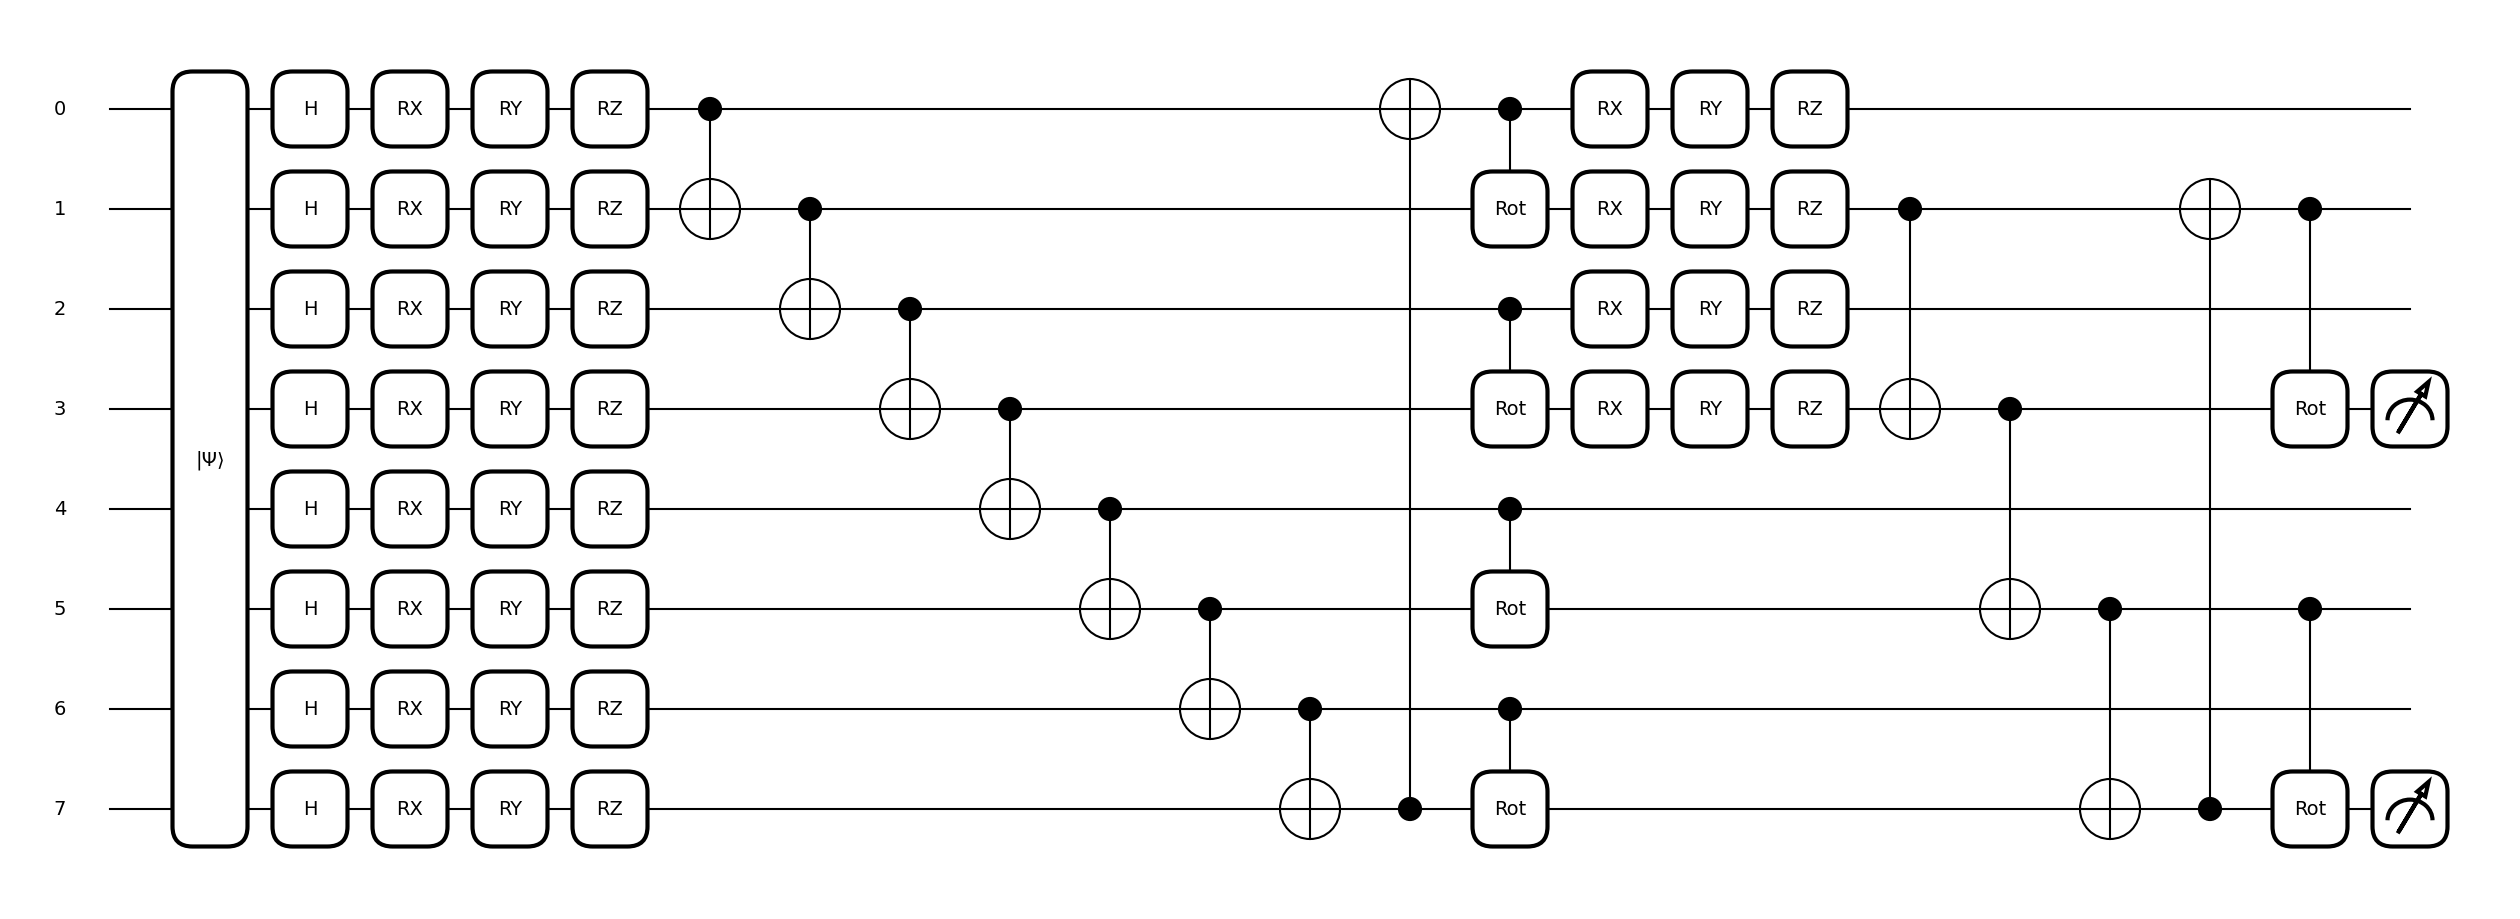

In [ ]:
qml.draw_mpl(qnode)(batch_X,model.params)

모델 테스트

In [ ]:
def validate_for_submission_with_loss(model, test_loader, device):
    model.eval()
    correct_raw = 0
    total_raw_loss = 0.0
    total_norm_loss = 0.0
    total = 0

    criterion = torch.nn.CrossEntropyLoss()
    eps = 1e-6

    print("\n" + "="*40)
    print("🔍 SUBMISSION VALIDATION REPORT")
    print("="*40)

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 1. 모델 출력 (순수 확률값)
            probs = model(batch_X)

            # 2. Pure Loss (정규화 없이 계산)
            # 확률값이 0~1 사이이므로 log를 취해 계산하는 CrossEntropy 사용
            # (만약 CrossEntropy가 내부적으로 Softmax를 적용하는 게 싫다면
            #  직접 log(probs) + NLLLoss 조합을 써도 됩니다.)
            raw_loss = torch.nn.functional.cross_entropy(probs, batch_y)
            total_raw_loss += raw_loss.item()

            # 3. Normalized Loss (학습 시 사용했던 수식 적용)
            mean = probs.mean(dim=-1, keepdim=True)
            std = probs.std(dim=-1, keepdim=True)
            norm_probs = (probs - mean) / (std + eps)
            norm_loss = criterion(norm_probs, batch_y)
            total_norm_loss += norm_loss.item()

            # 4. Accuracy (정규화 없는 순수 상태 기준)
            pred_raw = torch.argmax(probs, dim=1)
            correct_raw += (pred_raw == batch_y).sum().item()
            total += batch_y.size(0)

    avg_raw_loss = total_raw_loss / len(test_loader)
    avg_norm_loss = total_norm_loss / len(test_loader)
    acc_raw = correct_raw / total

    print(f"📉 Avg Pure Loss (No Norm)  : {avg_raw_loss:.6f}")
    print(f"📉 Avg Norm Loss (Trainer)  : {avg_norm_loss:.6f}")
    print(f"🎯 Pure Accuracy (No Norm)  : {acc_raw*100:.2f}%")
    print("-" * 40)

    # 분석 가이드
    loss_gap = abs(avg_raw_loss - avg_norm_loss)
    if loss_gap > 1.0:
        print("⚠️ [의존성 경고] Norm 적용 여부에 따른 Loss 차이가 큽니다.")
        print("   제출 전 'Fine-tuning'을 통해 Pure Loss를 낮추는 것을 추천합니다.")
    elif acc_raw > 0.8:
        print("🚀 [최종 통과] 파라미터가 매우 안정적입니다. 지금 바로 QASM을 추출하세요!")
    else:
        print("💡 [팁] 정확도가 낮다면 에포크를 늘리거나 학습률을 조정해 보세요.")
    print("="*40 + "\n")

# 실행
validate_for_submission_with_loss(model, train_loader, device)


🔍 SUBMISSION VALIDATION REPORT
📉 Avg Pure Loss (No Norm)  : 1.172934
📉 Avg Norm Loss (Trainer)  : 0.346528
🎯 Pure Accuracy (No Norm)  : 100.00%
----------------------------------------
🚀 [최종 통과] 파라미터가 매우 안정적입니다. 지금 바로 QASM을 추출하세요!



#모델 export

In [135]:
import json

# 1. Specify measurement qubits
measurements = [6, 7]

# 2. Extract trained parameters
params = model.params.detach().cpu().numpy()

# 3. Define circuit for QASM conversion (Ansatz only, no StatePrep or Measurement)
@qml.qnode(dev, interface='torch')
def Classifier(params):
    Quantum_block2(params)
    return qml.probs(wires=[0, 1])

# 4. Generate OpenQASM string
qasm_data = qml.to_openqasm(Classifier, measure_all=False)(params)

print(f"✅ Measurement Qubits: {measurements}")
print(f"✅ QASM Data Generated (Length: {len(qasm_data)} characters)")
print("--- QASM Preview (First 10 lines) ---")
print("\n".join(qasm_data.split('\n')[:]))


with open("./baseline.json", "w") as f:
    json.dump({
        "qasm": qasm_data,
        "measurements": measurements
    }, f)
print("✅ Submission file 'baseline.json' created.")

✅ Measurement Qubits: [6, 7]
✅ QASM Data Generated (Length: 3128 characters)
--- QASM Preview (First 10 lines) ---
OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];
h q[6];
h q[7];
cx q[0],q[1];
cx q[1],q[2];
cx q[2],q[3];
cx q[3],q[4];
cx q[4],q[5];
cx q[5],q[6];
cx q[6],q[7];
cx q[7],q[0];
rx(0.2948733) q[0];
ry(-0.031077327) q[0];
rz(0.27308032) q[0];
rx(0.084291816) q[1];
ry(0.07473012) q[1];
rz(0.09156674) q[1];
rx(-0.6011381) q[2];
ry(-0.33578455) q[2];
rz(0.27203038) q[2];
rx(-0.25757134) q[3];
ry(-0.12517215) q[3];
rz(0.11116404) q[3];
rx(-0.025359534) q[4];
ry(-0.3176729) q[4];
rz(0.30688766) q[4];
rx(-0.104574285) q[5];
ry(0.3081312) q[5];
rz(-0.24508141) q[5];
rx(0.41424102) q[6];
ry(-0.67388415) q[6];
rz(-0.2117969) q[6];
rx(-0.4269631) q[7];
ry(-0.26132664) q[7];
rz(0.2846781) q[7];
cx q[0],q[2];
cx q[1],q[3];
cx q[2],q[4];
cx q[3],q[5];
cx q[4],q[6];
cx q[5],q[7];
cx q[6],q[0];
cx q[7],q[1];
rx(-0.44016078) q[0];
ry(

qreg q[8];
creg c[8];
rz(0.40498495) q[0];
ry(0.15300891) q[0];
rz(0.46771476) q[0];
rz(0.23690376) q[1];
ry(0.093031146) q[1];
rz(0.2598675) q[1];

In [136]:
from google.colab import files
files.download('baseline.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>